In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(reshape2)
library(ggsci)
library(rstatix)
library(ggpubr)
library(ggplot2) 
library(GGally) 
library(pheatmap)



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [19]:

is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  } else {return('black')}
}

In [20]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read composite score

In [21]:
df<-read.csv('01_CompositeScore/BRI_CompositeScore.csv') %>% filter(sample.visitName=='Flu Year 1 Day 0')

In [22]:
colnames(df)

[1] "X.1"                                      
 [2] "pbmc_sample_id"                           
 [3] "composite_score_sum_mean"                 
 [4] "composite_score_sum_scaled_mean"          
 [5] "X"                                        
 [6] "Unnamed..0"                               
 [7] "lastUpdated"                              
 [8] "sample.id"                                
 [9] "sample.bridgingControl"                   
[10] "sample.sampleKitGuid"                     
[11] "sample.visitName"                         
[12] "sample.visitDetails"                      
[13] "sample.drawDate"                          
[14] "sample.daysSinceFirstVisit"               
[15] "file.id"                                  
[16] "file.name"                                
[17] "file.batchID"                             
[18] "file.panel"                               
[19] "file.pool"                                
[20] "file.fileType"                            
[21] "file.majorVersion"                        
[22] "subject.id"                               
[23] "subject.biologicalSex"                    
[24] "subject.birthYear"                        
[25] "subject.ethnicity"                        
[26] "subject.partnerCode"                      
[27] "subject.race"                             
[28] "subject.subjectGuid"                      
[29] "cohort.cohortGuid"                        
[30] "sample.diseaseStatesRecordedAtVisit"      
[31] "subject.covidVaxDose1.daysSinceFirstVisit"
[32] "subject.covidVaxDose2.daysSinceFirstVisit"
[33] "Covid_exclusion"                          
[34] "subjectGuid"                              
[35] "CMV"                                      
[36] "Ages"                                     
[37] "celltype"                                 
[38] "AgeGroup"

In [23]:
celltype_order <- c("CM CD4 T cell","Core naive CD8 T cell","CM CD8 T cell","GZMK+ CD27+ EM CD8 T cell" )
df<-df %>% filter(celltype %in% celltype_order)


In [24]:
df$celltype <- factor(df$celltype,levels=celltype_order)
#df$celltype<-gsub(' cell','',df$celltype)

# Plotting

In [25]:
df$`Age Group`<-df$`AgeGroup`

In [26]:
df$`Age Group`<-factor(df$`Age Group`,level=c('Young','Older'))

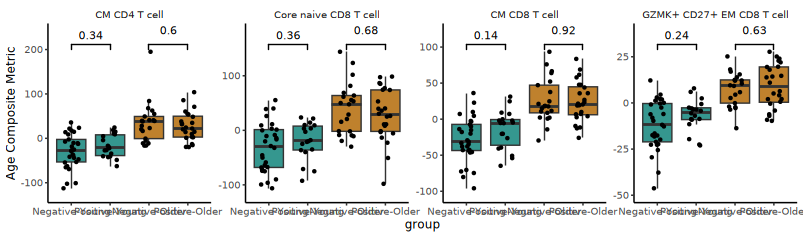

In [41]:
options(repr.plot.width = 170/25.4, repr.plot.height =  50/25.4)
df$group=paste0(df$CMV,'-',df$`Age Group`)
df$group=factor(df$group,levels=c("Negative-Young","Positive-Young","Negative-Older", "Positive-Older"))
my_comparisons <- list(c("Negative-Young", "Positive-Young"),c("Negative-Older", "Positive-Older"))
p <- ggplot(df  ,
              aes(x = group, y = composite_score_sum_scaled_mean)) +
    geom_boxplot( lwd=0.3, outlier.shape = NA,aes(fill = `Age Group`))+
    geom_point(aes(y = composite_score_sum_scaled_mean), 
               position = position_jitter(width = 0.2), color="black", size=1, stroke=0) +
    facet_wrap(~ celltype, scales = 'free_y', ncol = 4)   +
stat_compare_means(aes(label = paste0("p=", after_stat(p.format))),comparisons=my_comparisons[1],
    size=2.2,
    vjust = -0.5)+  
stat_compare_means(aes(label = paste0("p=", after_stat(p.format))),comparisons=my_comparisons[2],
    size=2.2,
    vjust = -1.1)+
    theme_classic(base_size = 7) +
    scale_fill_manual(values = c("Older" = '#bf812d', 
                                 "Young" = '#35978f')) +
    scale_y_continuous(limits = c(NA, NA), 
                       expand = expansion(mult = c(0.1, 0.15)))+
ylab('Age Composite Metric')+ 
guides(shape = guide_legend(override.aes = list(size = 0.5)))+
    theme(axis.line = element_line(colour = "black"),
          legend.position = "none",
          legend.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          strip.background = element_rect(linewidth = 0),
          axis.title.x = element_text(margin = margin(t = 2)))
p


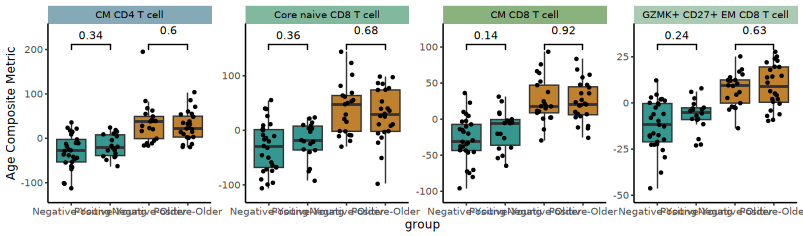

In [44]:
plot <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', plot$layout$name))

pal <- color_vector[celltype_order]
text_color <- sapply(color_vector[celltype_order], is_dark_color)

for (i in seq_along(strips)) {
  k <- which(grepl('rect', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- adjustcolor(pal[i], alpha.f = 0.8)
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(plot)
ggsave('FigureA.pdf',plot,width = 160/25.4, height =  50/25.4)